In [1]:
import numpy as np
from math import sqrt, pi,log, e
from enum import Enum
import scipy.stats as stat
from scipy.stats import norm
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm


In [2]:
class BSMerton:
    def __init__(self, args):
        self.Type = int(args[0])                # 1 for a Call, - 1 for a put
        self.S = float(args[1])                 # Underlying asset price
        self.K = float(args[2])                 # Option strike K
        self.r = float(args[3])                 # Continuous risk fee rate
        self.q = float(args[4])                 # Dividend continuous rate
        self.T = float(args[5]) / 365.0         # Compute time to expiry
        self.sigma = float(args[6])             # Underlying volatility
        self.sigmaT = self.sigma * self.T ** 0.5# sigma*T for reusability
        self.d1 = (log(self.S / self.K) + 
                   (self.r - self.q + 0.5 * (self.sigma ** 2)) 
                   * self.T) / self.sigmaT
        self.d2 = self.d1 - self.sigmaT
        [self.Delta] = self.delta()
        [self.Gamma] = self.gamma()
        [self.Theta] = self.theta()
        [self.Vega] = self.vega()
        [self.Rho] = self.rho()
        [self.Volga] = self.volga()
        [self.Vanna] = self.vanna()
        [self.Price] = self.price()
    def price(self):
        df = e** -(self.r * self.T)
        dfq = e** -(self.q * self.T)
        prix = dfq*self.S*norm.cdf(self.Type*self.d1) - self.Type*self.K*df*norm.cdf(self.Type*self.d2)
        return[prix]
    
    def delta(self):
        dfq = e ** (-self.q * self.T)
        if self.Type == 1:
            return [dfq * norm.cdf(self.d1)]
        elif self.Type == -1:
            return [dfq * (norm.cdf(self.d1) - 1)]

    def gamma(self):
        return [e**(-self.q * self.T) * norm.pdf(self.d1)/(self.S * self.sigmaT)]
    
    def theta(self):
        df = e** -(self.r * self.T)
        dfq = e** -(self.q * self.T)
        tmptheta = -self.Type*self.r * self.K*df*norm.cdf(self.d2) + self.Type* self.q*self.S*dfq*norm.cdf(self.Type*self.d1) - self.S*dfq*norm.pdf(self.d1)*self.sigma/(2*self.T**(1/2))
        
        annualized_theta = tmptheta  / 365.0
        return [annualized_theta]
    
    def vega(self):
        vega = self.S * math.exp(-self.q * self.T) * self.T** 0.5 * norm.pdf(self.d1)
        return [vega]
    
    def rho(self):
        rho = self.Type*self.K*e**(-(self.r -self.q)*self.T)*norm.cdf(self.Type*self.d2)
        return[rho]
    def volga(self):
        volga = self.Vega / self.sigma * self.d1 * self.d2
        return [volga]
    
    def vanna(self):
        vanna = -self.Vega / (self.S * self.sigma * self.T** 0.5) * self.d2
        return [vanna]
    

In [3]:
class Spread:
    def __init__(self, args):
        self.Call1 = args[0]
        self.Call2 = args[1]
        [self.Delta] = self.delta()
        [self.Gamma] = self.gamma()
        [self.Theta] = self.theta()
        [self.Vega] = self.vega()
    
    def delta(self):
        delta1 = self.Call1.Delta
        delta2 = self.Call2.Delta
        delta_final = delta1-delta2
        return[delta_final]
    
    def gamma(self):
        gamma1 = self.Call1.Gamma
        gamma2 = self.Call2.Gamma
        gamma_final = gamma1-gamma2
        return[gamma_final]
    
    def theta(self):
        theta1 = self.Call1.Theta
        theta2 = self.Call2.Theta
        theta_final = theta1-theta2
        return[theta_final]
    
    def vega(self):
        vega1 = self.Call1.Vega
        vega2 = self.Call2.Vega
        vega_final = vega1-vega2
        return[vega_final]

In [4]:
def plot3D(title, greek, xx, yy, zz):
    # Plot greek surface
    
    print("Plotting surface ...")
    fig = plt.figure()
    fig.suptitle(title, fontsize=20)
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, alpha=0.75, cmap=cm.RdYlBu)
    ax.set_xlabel('Asset price')
    ax.set_ylabel('Expiry')
    ax.set_zlabel(greek)

    # Plot 3D contour
    zzlevels = np.linspace(zz.min(),zz.max(),num=8,endpoint=True)
    xxlevels = np.linspace(xx.min(),xx.max(),num=8,endpoint=True)
    yylevels = np.linspace(yy.min(),yy.max(),num=8,endpoint=True)
    cset = ax.contourf(xx, yy, zz, zzlevels, zdir='z', offset=zz.min(),
                       cmap=cm.RdYlBu, linestyles='dashed')
    cset = ax.contourf(xx, yy, zz, xxlevels, zdir='x', offset=xx.min(),
                       cmap=cm.RdYlBu, linestyles='dashed')
    cset = ax.contourf(xx, yy, zz, yylevels, zdir='y', offset=yy.max(),
                       cmap=cm.RdYlBu, linestyles='dashed')
    for c in cset.collections:
        c.set_dashes([(0, (2.0, 2.0))]) # Dash contours

    plt.clabel(cset, fontsize=10, inline=1)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_zlim(zz.min(), zz.max())

    # Colorbar
    colbar = plt.colorbar(surf, shrink=1.0, extend='both', aspect=10)
    l, b, w, h = plt.gca().get_position().bounds
    ll, bb, ww, hh = colbar.ax.get_position().bounds
    colbar.ax.set_position([ll, b+0.1*h, ww, h*0.8])

    # Show chart
    plt.show()

In [5]:
# Option parameters
sigma = 0.12   # Flat volatility
strike = 105.0   # Fixed strike
epsilon = 0.4   # The % on the left/right of Strike.

# Asset prices are centered around Spot ("ATM Spot")
shortexpiry = 30   # Shortest expiry in days
longexpiry = 720   # Longest expiry in days
riskfree = 0.00   # Continuous risk free rate
divrate = 0.00   # Continuous div rate

# Grid definition
dx, dy = 40, 40   # Steps throughout asset price and expiries axis

# xx: Asset price axis, yy: expiry axis, zz: greek axis

xx, yy = np.meshgrid(np.linspace(strike*(1-epsilon), (1+epsilon)*strike, dx), 
                     np.linspace(shortexpiry, longexpiry, dy))

Plotting surface ...


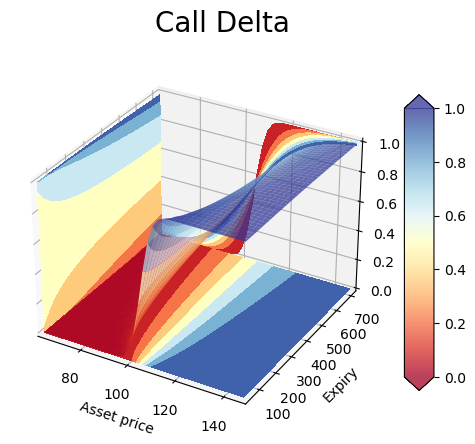

Sigma: 0.12
Strike: 105.0
Epsilon: 0.4
Short Expiry: 30
Long Expiry: 720
Risk-free Rate: 0.0
Dividend Rate: 0.0


In [6]:
xx, yy = np.meshgrid(np.linspace(strike*(1-epsilon), (1+epsilon)*strike, dx), 
                     np.linspace(shortexpiry, longexpiry, dy))

zz = np.array([BSMerton([1,x,strike,riskfree,divrate,y,sigma]).Delta
               for x,y in zip(np.ravel(xx), np.ravel(yy))])
zz = zz.reshape(xx.shape)

plot3D("Call Delta", "Delta", xx, yy, zz)

print("Sigma:", sigma)
print("Strike:", strike)
print("Epsilon:", epsilon)
print("Short Expiry:", shortexpiry)
print("Long Expiry:", longexpiry)
print("Risk-free Rate:", riskfree)
print("Dividend Rate:", divrate)

Plotting surface ...


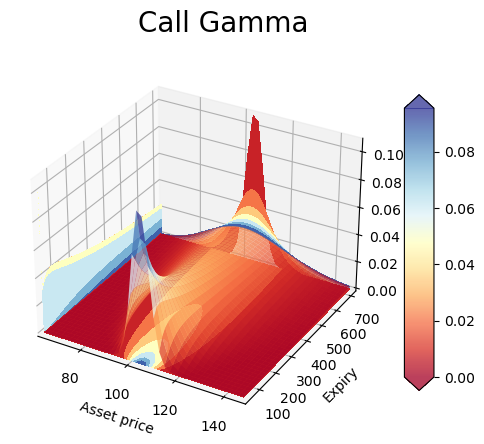

Sigma: 0.12
Strike: 105.0
Epsilon: 0.4
Short Expiry: 30
Long Expiry: 720
Risk-free Rate: 0.0
Dividend Rate: 0.0


In [7]:
zz = np.array([BSMerton([1,x,strike,riskfree,divrate,y,sigma]).Gamma 
               for x,y in zip(np.ravel(xx), np.ravel(yy))])
zz = zz.reshape(xx.shape)

plot3D("Call Gamma", "Gamma", xx, yy, zz)

print("Sigma:", sigma)
print("Strike:", strike)
print("Epsilon:", epsilon)
print("Short Expiry:", shortexpiry)
print("Long Expiry:", longexpiry)
print("Risk-free Rate:", riskfree)
print("Dividend Rate:", divrate)

Plotting surface ...


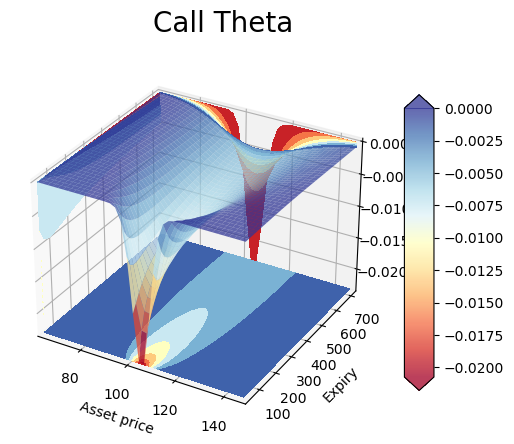

Sigma: 0.12
Strike: 105.0
Epsilon: 0.4
Short Expiry: 30
Long Expiry: 720
Risk-free Rate: 0.0
Dividend Rate: 0.0


In [8]:
zz = np.array([BSMerton([1,x,strike,riskfree,divrate,y,sigma]).Theta 
               for x,y in zip(np.ravel(xx), np.ravel(yy))])
zz = zz.reshape(xx.shape)

plot3D("Call Theta", "Theta", xx, yy, zz)

print("Sigma:", sigma)
print("Strike:", strike)
print("Epsilon:", epsilon)
print("Short Expiry:", shortexpiry)
print("Long Expiry:", longexpiry)
print("Risk-free Rate:", riskfree)
print("Dividend Rate:", divrate)

Plotting surface ...


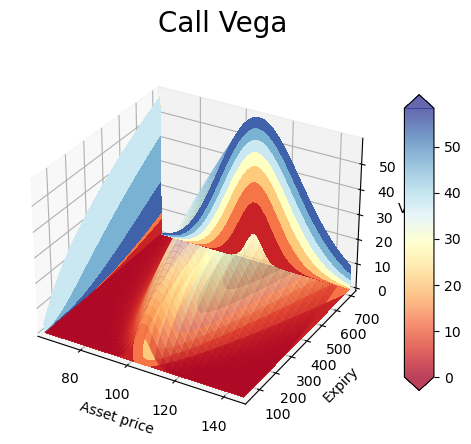

Sigma: 0.12
Strike: 105.0
Epsilon: 0.4
Short Expiry: 30
Long Expiry: 720
Risk-free Rate: 0.0
Dividend Rate: 0.0


In [9]:
zz = np.array([BSMerton([1,x,strike,riskfree,divrate,y,sigma]).Vega 
               for x,y in zip(np.ravel(xx), np.ravel(yy))])
zz = zz.reshape(xx.shape)

plot3D("Call Vega", "Vega", xx, yy, zz)

print("Sigma:", sigma)
print("Strike:", strike)
print("Epsilon:", epsilon)
print("Short Expiry:", shortexpiry)
print("Long Expiry:", longexpiry)
print("Risk-free Rate:", riskfree)
print("Dividend Rate:", divrate)

Plotting surface ...


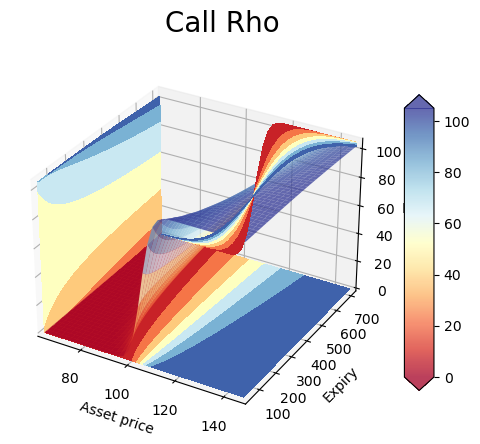

Sigma: 0.12
Strike: 105.0
Epsilon: 0.4
Short Expiry: 30
Long Expiry: 720
Risk-free Rate: 0.0
Dividend Rate: 0.0


In [10]:
zz = np.array([BSMerton([1,x,strike,riskfree,divrate,y,sigma]).Rho 
               for x,y in zip(np.ravel(xx), np.ravel(yy))])
zz = zz.reshape(xx.shape)

plot3D("Call Rho", "Rho", xx, yy, zz)

print("Sigma:", sigma)
print("Strike:", strike)
print("Epsilon:", epsilon)
print("Short Expiry:", shortexpiry)
print("Long Expiry:", longexpiry)
print("Risk-free Rate:", riskfree)
print("Dividend Rate:", divrate)

In [11]:
zz = np.array([BSMerton([1,x,strike,riskfree,divrate,y,sigma]).Volga 
               for x,y in zip(np.ravel(xx), np.ravel(yy))])
zz = zz.reshape(xx.shape)

plot3D("Call Volga", "Volga", xx, yy, zz)

print("Sigma:", sigma)
print("Strike:", strike)
print("Epsilon:", epsilon)
print("Short Expiry:", shortexpiry)
print("Long Expiry:", longexpiry)
print("Risk-free Rate:", riskfree)
print("Dividend Rate:", divrate)

Plotting surface ...


Sigma: 0.12
Strike: 105.0
Epsilon: 0.4
Short Expiry: 30
Long Expiry: 720
Risk-free Rate: 0.0
Dividend Rate: 0.0


Plotting surface ...


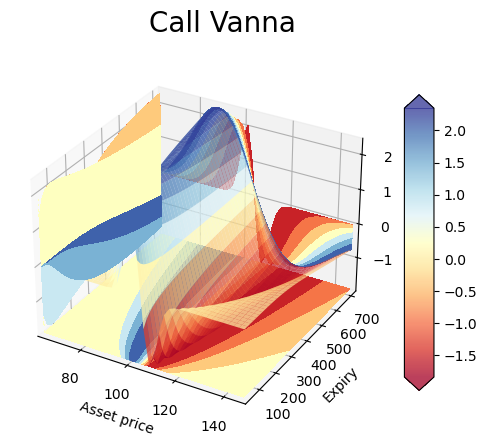

Sigma: 0.12
Strike: 105.0
Epsilon: 0.4
Short Expiry: 30
Long Expiry: 720
Risk-free Rate: 0.0
Dividend Rate: 0.0


In [12]:
zz = np.array([BSMerton([1,x,strike,riskfree,divrate,y,sigma]).Vanna
               for x,y in zip(np.ravel(xx), np.ravel(yy))])
zz = zz.reshape(xx.shape)

plot3D("Call Vanna", "Vanna", xx, yy, zz)

print("Sigma:", sigma)
print("Strike:", strike)
print("Epsilon:", epsilon)
print("Short Expiry:", shortexpiry)
print("Long Expiry:", longexpiry)
print("Risk-free Rate:", riskfree)
print("Dividend Rate:", divrate)

# Call spread

In [13]:
strike1=105
strike2=110
zz = np.array([Spread([BSMerton([1,x,strike1,riskfree,divrate,y,sigma]), BSMerton([1,x,strike2,riskfree,divrate,y,sigma])]).Delta
               for x,y in zip(np.ravel(xx), np.ravel(yy))])
zz = zz.reshape(xx.shape)

plot3D("Call Spread Delta", "Delta", xx, yy, zz)

print("Sigma:", sigma)
print("Strike long position:", strike1)
print("Strike short position:", strike2)
print("Epsilon:", epsilon)
print("Short Expiry:", shortexpiry)
print("Long Expiry:", longexpiry)
print("Risk-free Rate:", riskfree)
print("Dividend Rate:", divrate)

Plotting surface ...


Sigma: 0.12
Strike long position: 105
Strike short position: 110
Epsilon: 0.4
Short Expiry: 30
Long Expiry: 720
Risk-free Rate: 0.0
Dividend Rate: 0.0


In [14]:
strike1=90
strike2=130
zz = np.array([Spread([BSMerton([1,x,strike1,riskfree,divrate,y,sigma]), BSMerton([1,x,strike2,riskfree,divrate,y,sigma])]).Gamma
               for x,y in zip(np.ravel(xx), np.ravel(yy))])
zz = zz.reshape(xx.shape)

plot3D("Call Spread Gamma", "Gamma", xx, yy, zz)

print("Sigma:", sigma)
print("Strike long position:", strike1)
print("Strike short position:", strike2)
print("Epsilon:", epsilon)
print("Short Expiry:", shortexpiry)
print("Long Expiry:", longexpiry)
print("Risk-free Rate:", riskfree)
print("Dividend Rate:", divrate)

Plotting surface ...


Sigma: 0.12
Strike long position: 90
Strike short position: 130
Epsilon: 0.4
Short Expiry: 30
Long Expiry: 720
Risk-free Rate: 0.0
Dividend Rate: 0.0


In [15]:
strike1=105
strike2=110
zz = np.array([Spread([BSMerton([1,x,strike1,riskfree,divrate,y,sigma]), BSMerton([1,x,strike2,riskfree,divrate,y,sigma])]).Theta
               for x,y in zip(np.ravel(xx), np.ravel(yy))])
zz = zz.reshape(xx.shape)

plot3D("Call Spread Theta", "Theta", xx, yy, zz)

print("Sigma:", sigma)
print("Strike long position:", strike1)
print("Strike short position:", strike2)
print("Epsilon:", epsilon)
print("Short Expiry:", shortexpiry)
print("Long Expiry:", longexpiry)
print("Risk-free Rate:", riskfree)
print("Dividend Rate:", divrate)

Plotting surface ...


Sigma: 0.12
Strike long position: 105
Strike short position: 110
Epsilon: 0.4
Short Expiry: 30
Long Expiry: 720
Risk-free Rate: 0.0
Dividend Rate: 0.0


Plotting surface ...


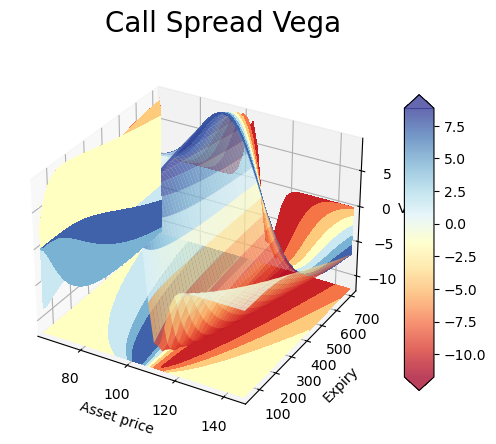

Sigma: 0.12
Strike long position: 105
Strike short position: 110
Epsilon: 0.4
Short Expiry: 30
Long Expiry: 720
Risk-free Rate: 0.0
Dividend Rate: 0.0


In [16]:
strike1=105
strike2=110
zz = np.array([Spread([BSMerton([1,x,strike1,riskfree,divrate,y,sigma]), BSMerton([1,x,strike2,riskfree,divrate,y,sigma])]).Vega
               for x,y in zip(np.ravel(xx), np.ravel(yy))])
zz = zz.reshape(xx.shape)

plot3D("Call Spread Vega", "Vega", xx, yy, zz)

print("Sigma:", sigma)
print("Strike long position:", strike1)
print("Strike short position:", strike2)
print("Epsilon:", epsilon)
print("Short Expiry:", shortexpiry)
print("Long Expiry:", longexpiry)
print("Risk-free Rate:", riskfree)
print("Dividend Rate:", divrate)